In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
import torch
from tensorflow import keras
#import keras
# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

print(tf.__version__)

1.15.0


Using TensorFlow backend.


In [2]:
!unzip train_form_of_letters.zip #images

Archive:  train_form_of_letters.zip
  inflating: train_form_of_letters/1.jpg  
  inflating: train_form_of_letters/10.jpg  
  inflating: train_form_of_letters/100.jpg  
  inflating: train_form_of_letters/101.jpg  
  inflating: train_form_of_letters/102.jpg  
  inflating: train_form_of_letters/103.jpg  
  inflating: train_form_of_letters/104.jpg  
  inflating: train_form_of_letters/105.jpg  
  inflating: train_form_of_letters/106.jpg  
  inflating: train_form_of_letters/107.jpg  
  inflating: train_form_of_letters/108.jpg  
  inflating: train_form_of_letters/109.jpg  
  inflating: train_form_of_letters/11.jpg  
  inflating: train_form_of_letters/110.jpg  
  inflating: train_form_of_letters/111.jpg  
  inflating: train_form_of_letters/112.jpg  
  inflating: train_form_of_letters/113.jpg  
  inflating: train_form_of_letters/114.jpg  
  inflating: train_form_of_letters/115.jpg  
  inflating: train_form_of_letters/116.jpg  
  inflating: train_form_of_letters/117.jpg  
  inflating: train_form

In [0]:
train = pd.read_csv('train_form_of_letters.csv')

In [4]:
train.head()

,img,form
0,1.jpg,2
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1


In [5]:
train.shape

(817, 2)

In [6]:
train[train.form == 0].shape, train[train.form == 1].shape, train[train.form == 2].shape #кол-во классов

((237, 2), (302, 2), (278, 2))

In [7]:
!unzip test_form_of_letters.zip #images

Archive:  test_form_of_letters.zip
  inflating: test_form_of_letters/100.jpg  
  inflating: test_form_of_letters/101.jpg  
  inflating: test_form_of_letters/102.jpg  
  inflating: test_form_of_letters/103.jpg  
  inflating: test_form_of_letters/104.jpg  
  inflating: test_form_of_letters/105.jpg  
  inflating: test_form_of_letters/106.jpg  
  inflating: test_form_of_letters/107.jpg  
  inflating: test_form_of_letters/108.jpg  
  inflating: test_form_of_letters/109.jpg  
  inflating: test_form_of_letters/110.jpg  
  inflating: test_form_of_letters/111.jpg  
  inflating: test_form_of_letters/112.jpg  
  inflating: test_form_of_letters/113.jpg  
  inflating: test_form_of_letters/114.jpg  
  inflating: test_form_of_letters/115.jpg  
  inflating: test_form_of_letters/116.jpg  
  inflating: test_form_of_letters/117.jpg  
  inflating: test_form_of_letters/118.jpg  
  inflating: test_form_of_letters/119.jpg  
  inflating: test_form_of_letters/120.jpg  
  inflating: test_form_of_letters/121.jpg

In [0]:
test = pd.read_csv('test_form_of_letters.csv')

In [9]:
test.head()

,img,form
0,100.jpg,1
1,101.jpg,1
2,102.jpg,1
3,103.jpg,1
4,104.jpg,1


In [10]:
test.shape

(158, 2)

In [11]:
test[test.form == 0].shape, test[test.form == 1].shape, test[test.form == 2].shape #кол-во классов

((49, 2), (57, 2), (52, 2))

In [0]:
hei = 128
wei = 64

**Добавление данных в x_test, y_test**

In [13]:
x_test = []
y_test = []

for i in range (test.shape[0]):
    x,y = test.values[i]
    x = cv2.imread('test_form_of_letters/{}'.format(x))
    #x = strong_aug(p=0.2)
    x = cv2.resize(x, (hei, wei))
    x_test += [x]
    y_test += [y]
    
x_test = np.array(x_test) / 255.
y_test = np.array(y_test)

x_test.shape

(158, 64, 128, 3)

**Генератор батчей для train**

In [0]:
#Объявим генератор
def keras_generator(gen_df, batch_size):#генератор картинок в батч (создание батча)
    while True:
        x_train = []
        y_train = []
        

        for i in range (batch_size):

            x,y = train.sample(1).values[0]
            x = cv2.imread('train_form_of_letters/{}'.format(x))
            #x = strong_aug(p=0.2)
            x = cv2.resize(x, (hei, wei))
            x_train += [x]
            y_train += [y]

        #y_train = keras.utils.to_categorical(y_train,10)
        x_train = np.array(x_train) / 255.
        y_train = np.array(y_train)

        yield x_train, y_train

**Архитектура сети**

In [0]:
inp = Input(shape=(wei, hei, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)
pool_1 = Dropout(0.2)(pool_1)
pool_1 = BatchNormalization()(pool_1)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)
pool_2 = Dropout(0.2)(pool_2)
pool_2 = BatchNormalization()(pool_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2) #conv_3_2.shape = (64,64,128)

pool_3 = MaxPooling2D(2)(conv_3_2) #pool_3.shape = (32,32,128)
pool_3 = Dropout(0.2)(pool_3)
pool_3 = BatchNormalization()(pool_3)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2) #conv_4_2.shape = (32,32,256)

pool_4 = MaxPooling2D(2)(conv_4_2) #pool_4.shape = (16,16,256)
pool_4 = Dropout(0.2)(pool_4)
pool_4 = BatchNormalization()(pool_4)



flat = Flatten()(pool_4)
layer1 = Dense(128, activation='relu')(flat)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization()(layer1)

layer2 = Dense(256, activation='relu')(layer1)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization()(layer2)

layer3 = Dense(512, activation='relu')(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization()(layer3)

layer4 = Dense(64, activation='relu')(layer3)
layer4 = Dropout(0.2)(layer4)
layer4 = BatchNormalization()(layer4)

layer_out = Dense(3, activation='softmax')(layer4)

model = Model(inputs=inp, outputs=layer_out)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









In [0]:
#model.summary()

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Обучение через генератор, т.е. с батчами**

In [0]:
batch_size = 32
model.fit_generator(keras_generator(train, batch_size),
              steps_per_epoch=100,#каждую эпоху - 100 батчей
              epochs=30,
              verbose=1,#будем выводить результат
              shuffle=True)

Epoch 1/30
100/100 [==============================] - 9s 92ms/step - loss: 0.0680 - acc: 0.9816
Epoch 2/30
100/100 [==============================] - 9s 91ms/step - loss: 0.0551 - acc: 0.9806
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.0737 - acc: 0.9762
Epoch 4/30
100/100 [==============================] - 9s 91ms/step - loss: 0.0364 - acc: 0.9903
Epoch 5/30
100/100 [==============================] - 9s 91ms/step - loss: 0.0160 - acc: 0.9966
Epoch 6/30
100/100 [==============================] - 9s 91ms/step - loss: 0.0194 - acc: 0.9941
Epoch 7/30
  9/100 [=>............................] - ETA: 8s - loss: 0.0439 - acc: 0.9792

KeyboardInterrupt: ignored

In [0]:
for x_train,y_train in keras_generator(train,train.shape[0]):
    break

In [16]:
x_train.shape

(817, 64, 128, 3)

In [18]:
train_loss, train_acc = model.evaluate(x_train, y_train)

print('\nТочность на обучающих данных:', train_acc)
print('\nОшибка на обучающих данных:', train_loss)

817/817 [==============================] - 7s 9ms/sample - loss: 0.0298 - acc: 0.9853

Точность на обучающих данных: 0.9853121

Ошибка на обучающих данных: 0.02982841930129865


In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nТочность на проверочных данных:', test_acc)
print('\nОшибка на проверочных данных:', test_loss)

158/158 [==============================] - 0s 3ms/sample - loss: 1.8276 - acc: 0.6203

Точность на проверочных данных: 0.62025315

Ошибка на проверочных данных: 1.8276210072674328


In [17]:
#model.save('neural_network_form_of_letters.h5') #сохранение нейросети в файл

from tensorflow.keras.models import load_model
model = load_model('!!!62%!!!   neural_network_form_of_letters.h5') #загрузка нейросети из файла

#pred = model.predict(x_test) #предсказание

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
pred = model.predict(x_test)

In [21]:
pred.shape

(158, 3)

In [22]:
np.argmax(pred[15]),y_test[15]

(0, 0)

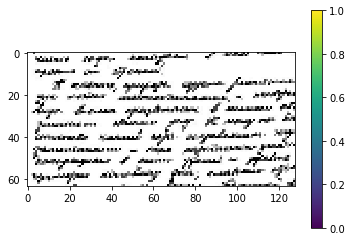

In [23]:
plt.figure()
plt.imshow(x_test[15])
plt.colorbar()
plt.grid(False)
plt.show()

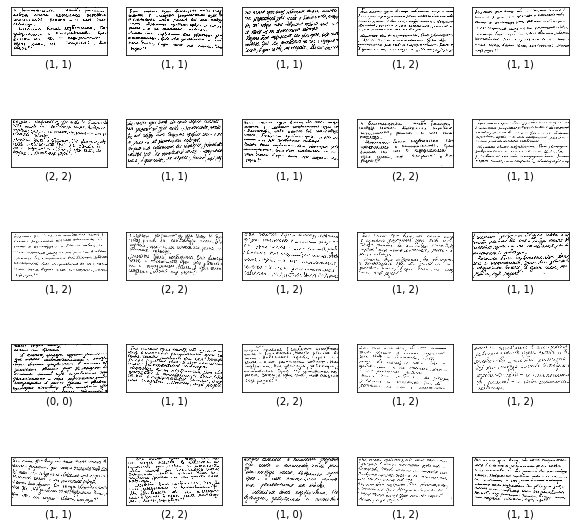

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel((y_test[i],np.argmax(pred[i])))
plt.show()

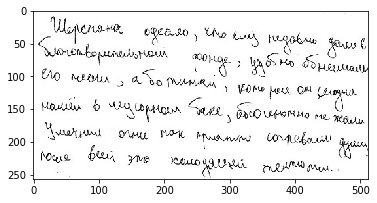

In [28]:
way='142.jpg'
#img = Image.open(way)
img = cv2.imread(way)
plt.imshow(img)
img = cv2.resize(img, (hei, wei)) / 255.

In [0]:
'''def binarize_array(numpy_array):
    """Binarize a numpy array."""
    for i in range(len(numpy_array)):
        for j in range(len(numpy_array[0])):
            if (numpy_array[i][j][0] > 150 and numpy_array[i][j][1] > 150 and numpy_array[i][j][2] > 150
                or numpy_array[i][j][0] > 180 or numpy_array[i][j][1] > 180 or numpy_array[i][j][2] > 180):
                numpy_array[i][j] = 255
            else:
                numpy_array[i][j] = 0
    return numpy_array
img = binarize_array(img)
img = cv2.resize(img, (hei, wei))
plt.imshow(img)'''

In [0]:
pred_img = model.predict(img.reshape(1,wei,hei,3))

In [30]:
print('Pred_img: ',np.argmax(pred_img))

Pred_img:  2
